In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob
import agama

from pyMND.forcetree import construct_tree, force_treeevaluate_loop

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [3]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [4]:
def read_bar_prop(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_bar_prop = prefix + 'bar_prop/data/'
    
    fin = prefix_bar_prop + 'bar_prop_' + name + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        if key=='bar_prop':
            out[key] = {}
            for k2 in h5in[key].keys():
                out[key][k2] = np.array(h5in[key][k2])
        else:
            out[key] = np.array(h5in[key])
    
    h5in.close()
    
    return out

In [5]:
idx_list = np.arange(0, 250)

torque_path = '/n/home01/abeane/starbar/plots/torques-rot/data'
gas30_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot30/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot30.'
gas35_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot35/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot35.'
gas40_base = torque_path + '/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot40/torques_phantom-vacuum-Sg20-Rc3.5-lvl3-rot40.'

tz_gas30 = []
tz_gas35 = []
tz_gas40 = []
time = []

for idx in tqdm(idx_list):
#     sn = read_snap(idx, 1, parttype=[0], fields=['Masses'])
    
    fname = gas30_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')    
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas30.append(torque_gas[2])
    time.append(t['parameters'].attrs['Time'])
    t.close()
    
    fname = gas35_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')    
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas35.append(torque_gas[2])
#     time.append(t['parameters'].attrs['Time'])
    t.close()
    
    fname = gas40_base + str(idx) + '.hdf5'
    t = h5.File(fname, mode='r')    
    torque_gas = t['total_torques'].attrs['gas']
    tz_gas40.append(torque_gas[2])
#     time.append(t['parameters'].attrs['Time'])
    t.close()


tz_gas30 = np.array(tz_gas30)
tz_gas35 = np.array(tz_gas35)
tz_gas40 = np.array(tz_gas40)
time = np.array(time)

A Jupyter Widget

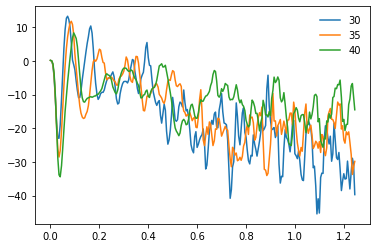

In [6]:
plt.plot(time, tz_gas30, label='30')
plt.plot(time, tz_gas35, label='35')
plt.plot(time, tz_gas40, label='40')

plt.legend(frameon=False)
plt.show()

In [7]:
print(np.mean(tz_gas30[50:250]))
print(np.mean(tz_gas35[50:250]))
print(np.mean(tz_gas40[50:250]))

-20.18398586919457
-16.8477944569044
-12.029357074827521


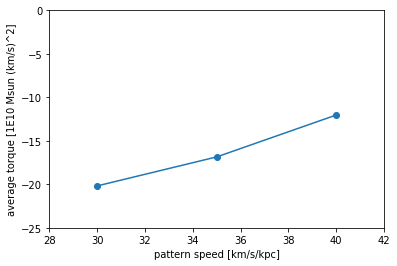

In [8]:
rot_list = [30, 35, 40]

tz_list = []
tz_list.append(np.mean(tz_gas30[50:250]))
tz_list.append(np.mean(tz_gas35[50:250]))
tz_list.append(np.mean(tz_gas40[50:250]))

plt.plot(rot_list, tz_list)
plt.scatter(rot_list, tz_list)

plt.xlabel('pattern speed [km/s/kpc]')
plt.ylabel('average torque [1E10 Msun (km/s)^2]')

plt.ylim(-25, 0)
plt.xlim(28, 42)
plt.show()

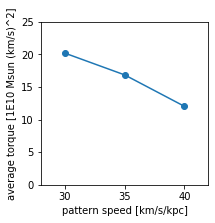

In [13]:
rot_list = [30, 35, 40]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

tz_list = []
tz_list.append(np.mean(tz_gas30[50:250]))
tz_list.append(np.mean(tz_gas35[50:250]))
tz_list.append(np.mean(tz_gas40[50:250]))
tz_list = np.array(tz_list)

ax.plot(rot_list, -tz_list)
ax.scatter(rot_list, -tz_list)

ax.set_xlabel('pattern speed [km/s/kpc]')
ax.set_ylabel('average torque [1E10 Msun (km/s)^2]')

ax.set_ylim(0, 25)
ax.set_xlim(28, 42)
plt.show()

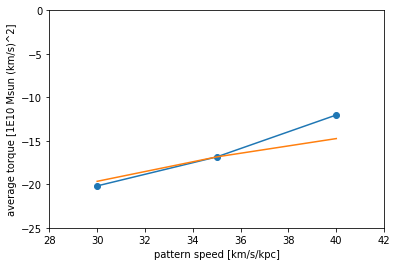

In [9]:
rot_list = [30, 35, 40]

tz_list = []
tz_list.append(np.mean(tz_gas30[50:250]))
tz_list.append(np.mean(tz_gas35[50:250]))
tz_list.append(np.mean(tz_gas40[50:250]))

plt.plot(rot_list, tz_list)
plt.scatter(rot_list, tz_list)

y = [tz_list[1] * (35/30), tz_list[1], tz_list[1] * (35/40)]

plt.plot(rot_list, y)

plt.xlabel('pattern speed [km/s/kpc]')
plt.ylabel('average torque [1E10 Msun (km/s)^2]')

plt.ylim(-25, 0)
plt.xlim(28, 42)
plt.show()